In [1]:
# install necessary libraries
!pip install opencv-python matplotlib

DEPRECATION: Loading egg at c:\users\qusai\appdata\local\programs\python\python311\lib\site-packages\gym-0.17.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\qusai\appdata\local\programs\python\python311\lib\site-packages\gym_maze_trustycoder83-0.0.4.post0.dev4+gff770ad-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\qusai\appdata\local\programs\python\python311\lib\site-packages\gym_maze_trustycoder83-0.0.4.post0.dev4+gff770ad.dirty-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.co

In [8]:
# import necessary libraries for plotting
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [9]:
# function to preprocess the image and convert it to binary format
def preprocess_image(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply binary thresholding to convert the image to binary format
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    return binary_image // 255

In [10]:
# function to plot the maze with start and end points
def plot_maze_with_points(grid, start, end, title="Maze with Start and End Points"):
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap='gray', origin='upper')
    # Start and end points are plotted with x and y inverted to match the indexing
    plt.scatter([start[1]], [start[0]], c='red', s=100, label='Start')  # Start point
    plt.scatter([end[1]], [end[0]], c='blue', s=100, label='End')  # End point
    plt.title(title)
    plt.legend()
    plt.grid(False)  # Hide the grid lines
    plt.axis('on')  # Show axes
    plt.show()

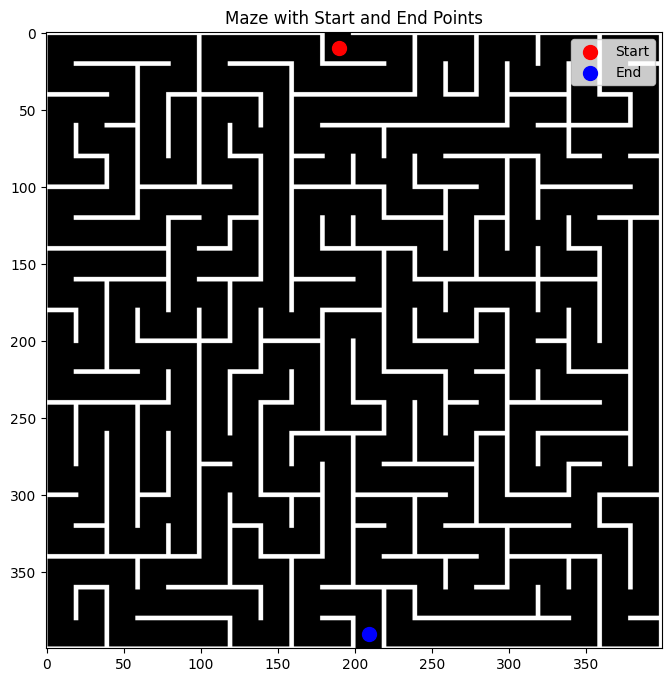

In [11]:
# Path to the maze image
image_path = 'maze.png'

# Process the image to get the binary maze grid
maze = preprocess_image(image_path)

# Set the start and end points (y, x) coordinates
start = (10, 190)  # Example start position
end = (390, 209)  # Example end position

# Visualize the maze with the start and end points
plot_maze_with_points(maze, start, end)

In [12]:
# check the maze
maze

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [13]:
maze.shape

(400, 400)

In [15]:
# assuring that the start and end points are not inside walls
start_value = maze[10, 190]  # Access the value at start point (row 10, column 190)
end_value = maze[390, 209]  # Access the value at end point (row 390, column 209)

print("Value at start point (10, 190):", start_value)
print("Value at end point (390, 209):", end_value)

Value at start point (10, 190): 0
Value at end point (390, 209): 0


In [17]:
# check if a move is valid (withing the grid boundaries and not a wall)
def is_valid_move(y, x, grid):
    return 0 <= y < grid.shape[0] and 0 <= x < grid.shape[1] and grid[y][x] == 0  # Open space


# Function to get the valid actions for a given state
def get_valid_actions_step(grid, current, step=10):
    actions = []
    directions = [(-step, 0), (step, 0), (0, -step), (0, step)]  # Up, Down, Left, Right
    for dy, dx in directions:
        ny, nx = current[0] + dy, current[1] + dx
        intermediate_steps = [
            (current[0] + i * (dy // step), current[1] + i * (dx // step))
            for i in range(1, step + 1)
        ]
        if all(0 <= y < grid.shape[0] and 0 <= x < grid.shape[1] and grid[y, x] == 0
               for y, x in intermediate_steps):
            actions.append((ny, nx))
    return actions


# function to initialize Q-values for the given maze using the step size (default 10)
def initialize_q_values_step(grid, step=10):
    q_values = {}
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            if grid[y][x] == 0:  # Open space
                actions = get_valid_actions_step(grid, (y, x), step)
                if actions:
                    q_values[(y, x)] = {action: 0 for action in actions}
    return q_values


# epsilon-greedy policy
def epsilon_greedy_step(q_values, state, epsilon=0.3):  # Moderate exploration rate
    if state not in q_values:
        return None  # No valid actions from this state
    if random.random() < epsilon:
        return random.choice(list(q_values[state].keys()))
    else:
        return max(q_values[state], key=q_values[state].get)


# checking if the agent reached the target (the maze has been solved)
def is_in_rectangle(point, rect):
    y, x = point
    (y1, x1), (y2, x2) = rect  # Top-left and bottom-right corners
    return y1 <= y <= y2 and x1 <= x <= x2


# funtion to calculate the reward for the given state and next state
def calculate_reward_with_distance(current, next_state, end_rect, path):
    """
    Reward function with a weak distance incentive toward the goal.
    """
    # Goal reward
    if is_in_rectangle(next_state, end_rect):
        return 100  # Strong reward for reaching the goal

    # Penalize oscillation (revisiting recent states)
    if next_state in path[-7:]:  # Penalize revisiting the last 7 states
        revisit_penalty = -10
    else:
        revisit_penalty = 0

    # Bonus for exploring new states
    if next_state not in path:
        exploration_bonus = 5
    else:
        exploration_bonus = 0

    # Distance-based incentive (weaker than goal reward)
    (y1, x1), (y2, x2) = end_rect
    goal_center = ((y1 + y2) / 2, (x1 + x2) / 2)
    distance_before = np.linalg.norm(np.array(current) - np.array(goal_center))
    distance_after = np.linalg.norm(np.array(next_state) - np.array(goal_center))
    distance_bonus = 2 if distance_after < distance_before else -2

    # Fixed step penalty
    step_penalty = -1

    # Total reward
    return step_penalty + revisit_penalty + exploration_bonus + distance_bonus


# function to update Q-value using the Q-learning update rule
def update_q_value(q_values, state, action, reward, next_state, alpha, gamma):
    future_value = max(q_values[next_state].values()) if next_state in q_values else 0
    q_values[state][action] += alpha * (reward + gamma * future_value - q_values[state][action])


In [18]:
def train_agent(grid, start, end_rect, episodes=5000, alpha=0.5, gamma=0.7, epsilon=0.3, step=10, visual_interval=100, max_steps=1000):
    """
    Train Q-learning agent with distance-based rewards, storing and emphasizing the best path.
    """
    q_values = initialize_q_values_step(grid, step)
    best_path = None
    best_reward = float('-inf')  # Initialize with the lowest possible reward

    for episode in range(episodes):
        current = start
        path = [start]
        total_reward = 0
        steps = 0

        while not is_in_rectangle(current, end_rect) and steps < max_steps:
            if current not in q_values:
                break
            action = epsilon_greedy_step(q_values, current, epsilon)
            if action is None:
                break
            next_state = action

            # Calculate reward with distance incentive
            reward = calculate_reward_with_distance(current, next_state, end_rect, path)

            total_reward += reward
            update_q_value(q_values, current, action, reward, next_state, alpha, gamma)
            current = next_state
            path.append(current)
            steps += 1

        # Check if the target was reached and update the best path
        if is_in_rectangle(current, end_rect):
            print(f"Target reached in Episode {episode + 1} with Reward: {total_reward:.2f}")
            if total_reward > best_reward:
                best_reward = total_reward
                best_path = path.copy()  # Store the best path
                print(f"New Best Path Found in Episode {episode + 1} with Reward: {best_reward:.2f}")

            # Emphasize learning from the best path
            for i in range(len(path) - 1):
                state, next_state = path[i], path[i + 1]
                reward = 100 if i == len(path) - 2 else -1  # Goal reward for last step
                update_q_value(q_values, state, next_state, reward, next_state, alpha * 2, gamma)  # Double alpha for emphasis

        # Print training progress
        print(f"Episode: {episode + 1}/{episodes}, Steps: {steps}/{max_steps}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.4f}")

        # Visualize progress at intervals
        if episode % visual_interval == 0 or episode == episodes - 1:
            plot_path_with_rect(grid, path, episode, step, end_rect, total_reward)

    # Visualize the best path after training
    if best_path:
        print(f"Best Path Reward: {best_reward:.2f}")
        plot_best_path(grid, best_path, step, end_rect, best_reward)

    return q_values


In [20]:
# function to plot the path for a specific episode, showing the reward in the title.
def plot_path_with_rect(grid, path, episode, step, end_rect, reward):
    """
    Plot the path for a specific episode, showing the reward in the title.
    """
    clear_output(wait=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap='Greys', interpolation='nearest')
    ys, xs = zip(*path)
    plt.plot(xs, ys, 'bo-', linewidth=2, markersize=5, label=f'Path (Step={step})')
    plt.scatter([start[1]], [start[0]], c='green', s=100, label='Start')

    # Highlight the rectangular end goal
    (y1, x1), (y2, x2) = end_rect
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=True, color='red', alpha=0.3, label='End Region'))

    plt.title(f"Episode: {episode}, Reward: {reward:.2f}")
    plt.legend()
    display(plt.gcf())
    plt.close()


In [82]:
# function to plot the best path after training ends, showing the reward in the title.
def plot_best_path(grid, best_path, step, end_rect, reward):
    """
    Visualize the best path after training ends, showing the reward in the title.
    """
    clear_output(wait=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap='Greys', interpolation='nearest')
    ys, xs = zip(*best_path)
    plt.plot(xs, ys, 'go-', linewidth=2, markersize=5, label=f'Best Path (Step={step})')
    plt.scatter([start[1]], [start[0]], c='green', s=100, label='Start')

    # Highlight the rectangular end goal
    (y1, x1), (y2, x2) = end_rect
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=True, color='red', alpha=0.3, label='Target Region'))

    plt.title(f"Best Path After Training, Reward: {reward:.2f}")
    plt.legend()
    plt.show()


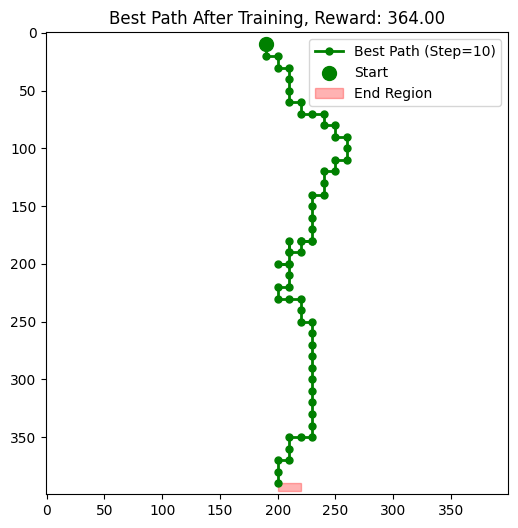

In [27]:
maze = np.zeros((400, 400))  # Empty space for initial evaluation. Had been replaced later with the actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (397, 220))  # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.7,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=70  # Shorter max steps
)

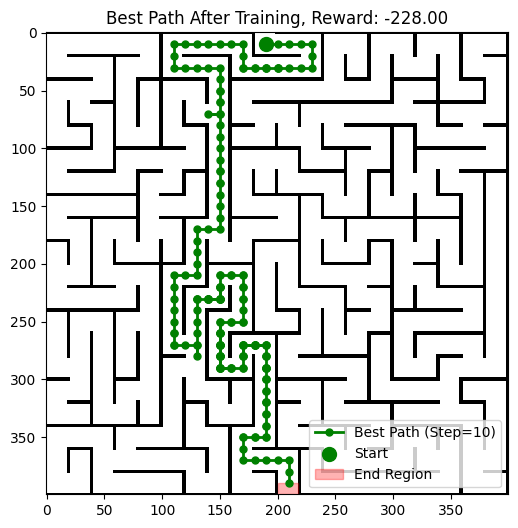

In [29]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (399, 218))  # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.7,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

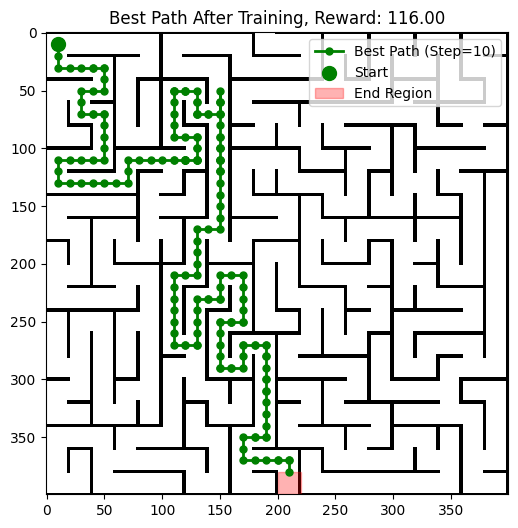

In [30]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 10)  # Start point
end_rect = ((380, 200), (399, 220))  # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

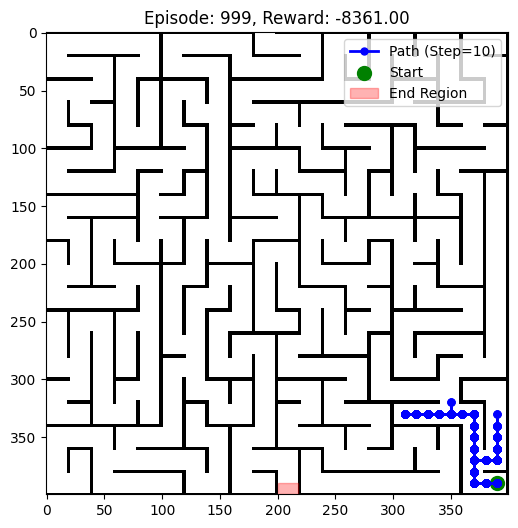

In [32]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

In [76]:
maze

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

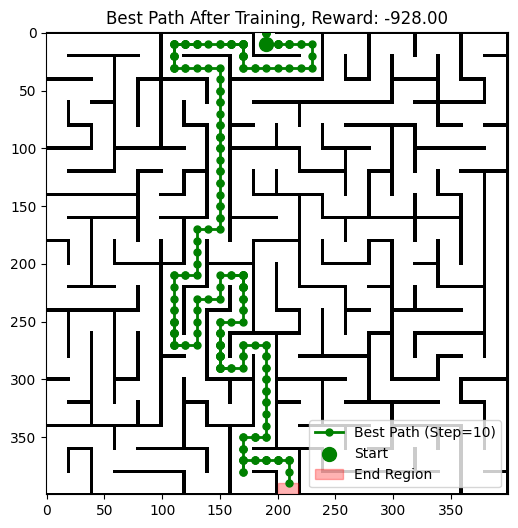

In [37]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*1  # Shorter max steps
)

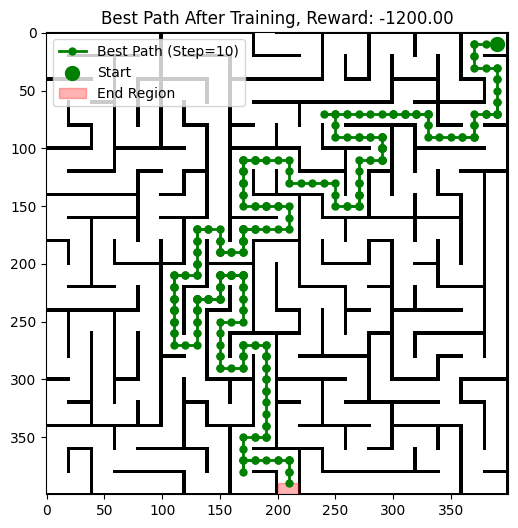

In [42]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

# Adaptive Training Function

In [43]:
def train_agent(grid, start, end_rect, episodes=5000, alpha=0.5, gamma=0.7, epsilon=0.3, step=10, visual_interval=100, max_steps=1000, epsilon_decay=0.995, target_reward=100):
    """
    Train a Q-learning agent with distance-based rewards, storing and emphasizing the best path, and emphasizing episodes where the target is reached.
    """
    q_values = initialize_q_values_step(grid, step)
    best_path = None
    best_reward = float('-inf')  # Initialize with the lowest possible reward

    for episode in range(episodes):
        current = start
        path = [start]
        total_reward = 0
        steps = 0

        while not is_in_rectangle(current, end_rect) and steps < max_steps:
            if current not in q_values:
                break
            action = epsilon_greedy_step(q_values, current, epsilon)
            if action is None:
                break
            next_state = action

            # Calculate reward with distance incentive
            reward = calculate_reward_with_distance(current, next_state, end_rect, path)
            total_reward += reward

            # Update Q-value normally
            update_q_value(q_values, current, action, reward, next_state, alpha, gamma)
            current = next_state
            path.append(current)
            steps += 1

        # Check if the target was reached and update the best path
        if is_in_rectangle(current, end_rect):
            print(f"Target reached in Episode {episode + 1} with Reward: {total_reward:.2f}")
            if total_reward > best_reward:
                best_reward = total_reward
                best_path = path.copy()  # Store the best path
                print(f"New Best Path Found in Episode {episode + 1} with Reward: {best_reward:.2f}")

            # Emphasize learning from the best path if target is reached
            for i in range(len(path) - 1):
                state, next_state = path[i], path[i + 1]
                reward = target_reward if i == len(path) - 2 else 0  # Significant goal reward for last step
                update_q_value(q_values, state, next_state, reward, next_state, alpha * 2, gamma)  # Double alpha for emphasis

        # Decay epsilon after each episode
        epsilon *= epsilon_decay

        # Print training progress
        print(f"Episode: {episode + 1}/{episodes}, Steps: {steps}/{max_steps}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.4f}")

        # Visualize progress at intervals
        if episode % visual_interval == 0 or episode == episodes - 1:
            plot_path_with_rect(grid, path, episode, step, end_rect, total_reward)

    # Visualize the best path after training
    if best_path:
        print(f"Best Path Reward: {best_reward:.2f}")
        plot_best_path(grid, best_path, step, end_rect, best_reward)

    return q_values


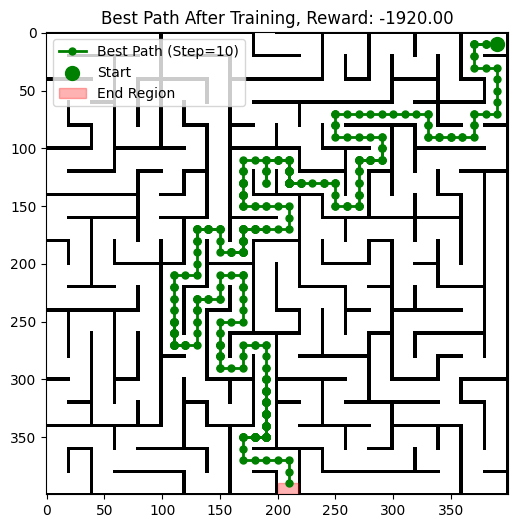

In [44]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

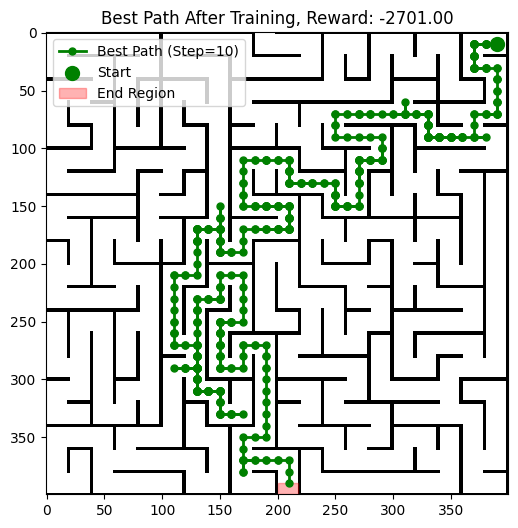

In [46]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

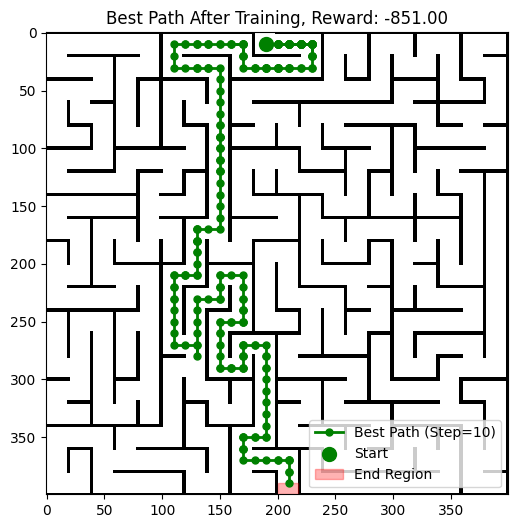

In [50]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

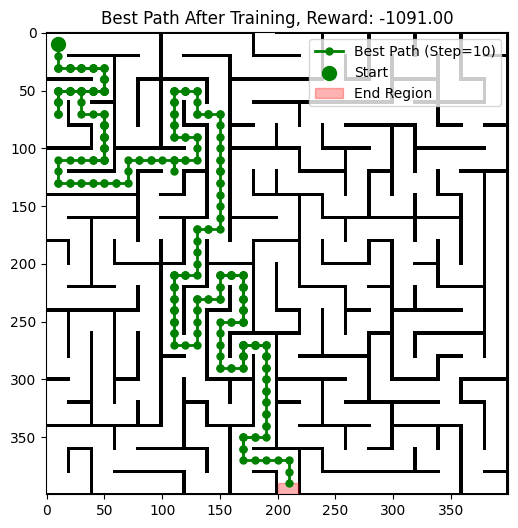

In [52]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

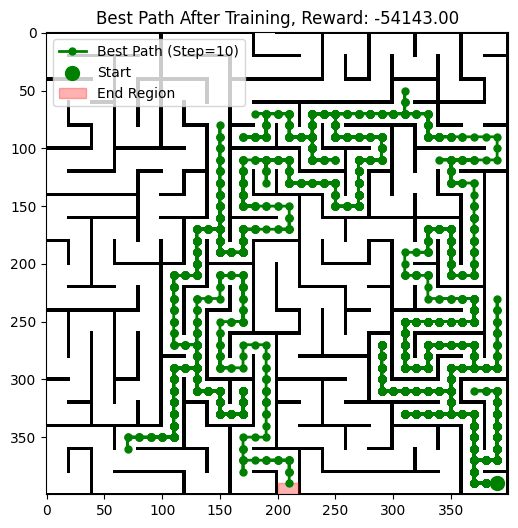

In [56]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*30  # Shorter max steps
)

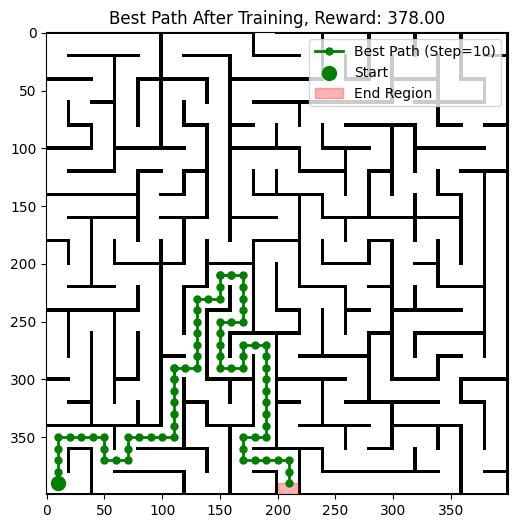

In [55]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

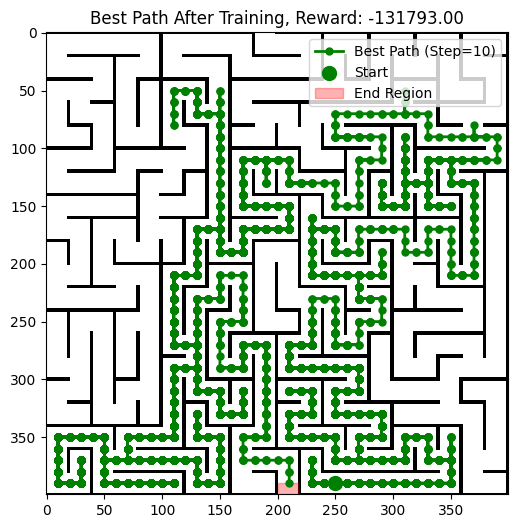

In [58]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 250)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*30  # Shorter max steps
)

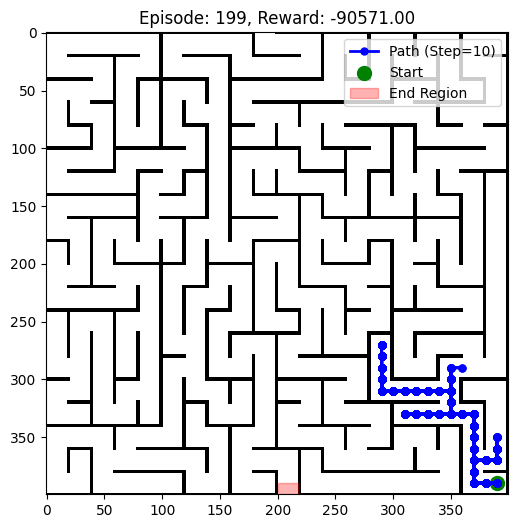

In [60]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

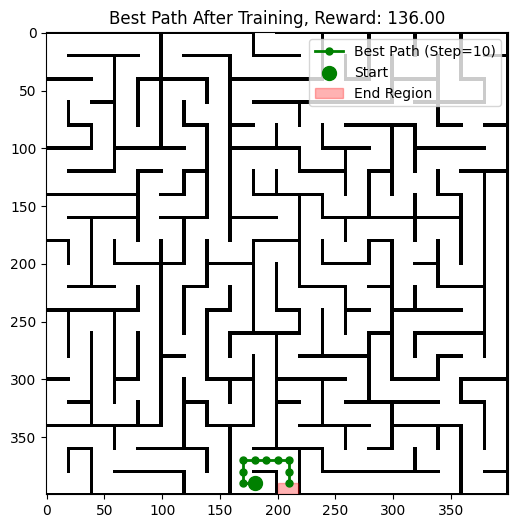

In [59]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 180)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

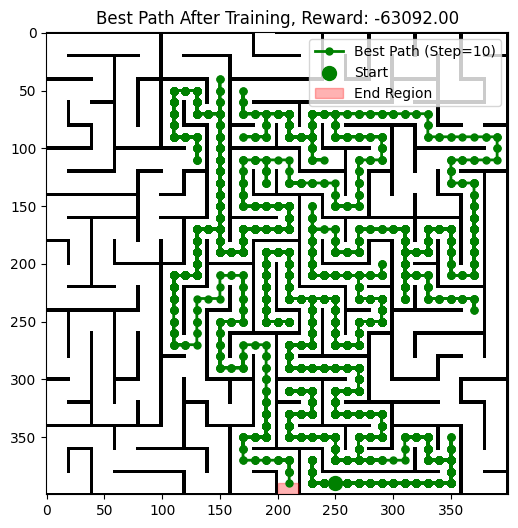

In [64]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 250)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*20  # Shorter max steps
)

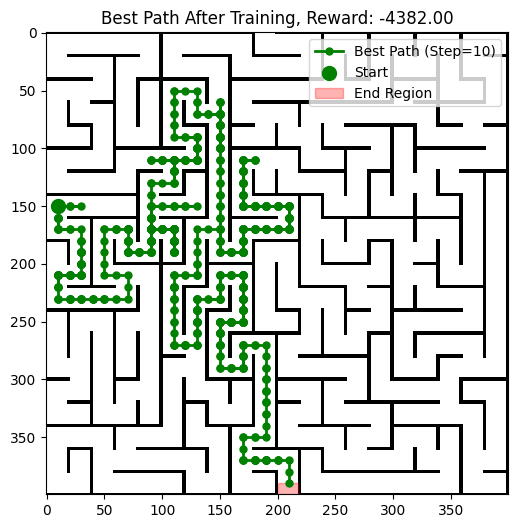

In [63]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (150, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=150,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

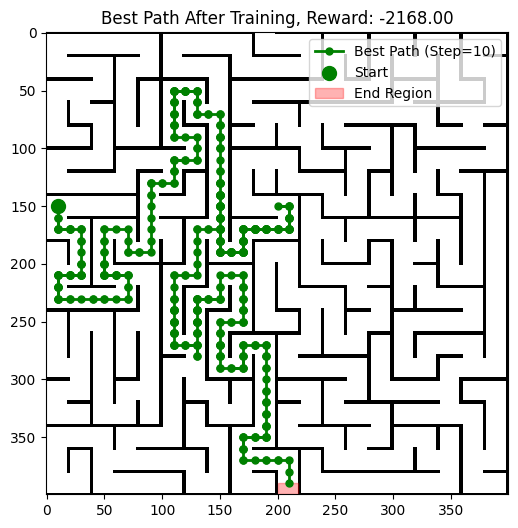

In [65]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (150, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=150,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*5  # Shorter max steps
)

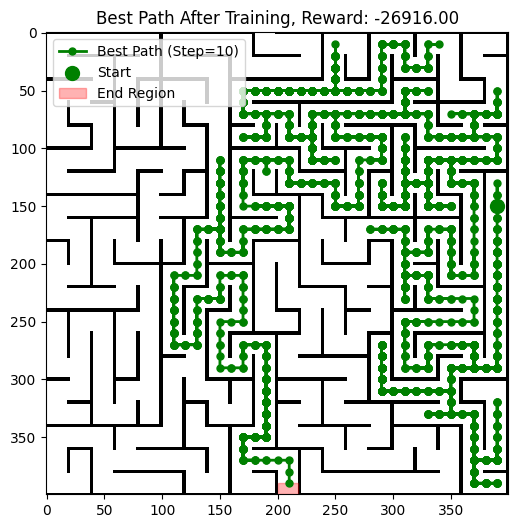

In [68]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (150, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

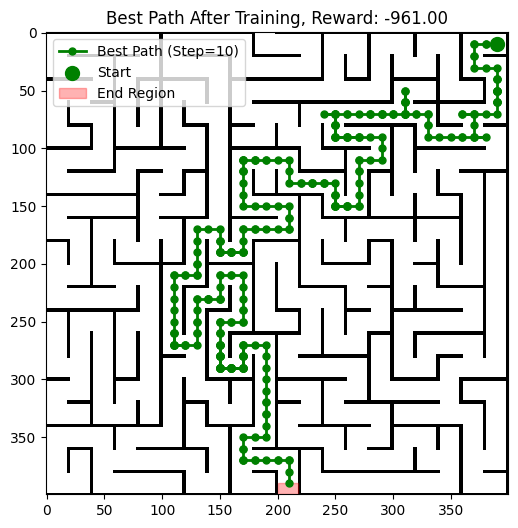

In [69]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

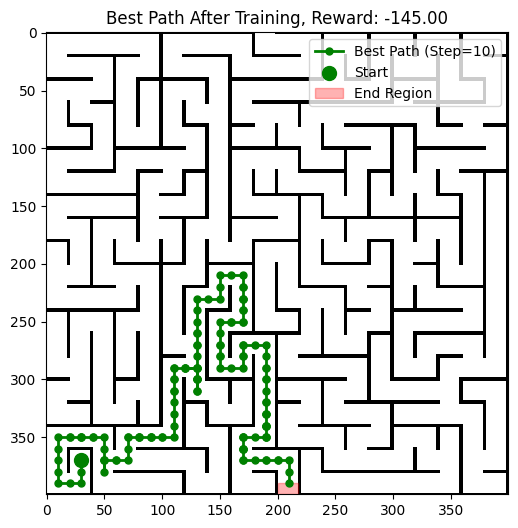

In [71]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (370, 30)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

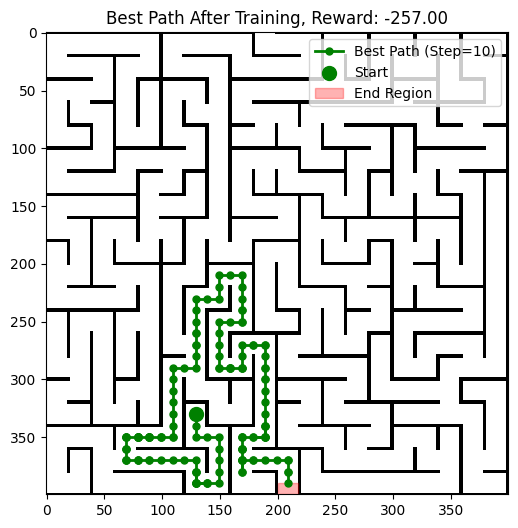

In [74]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (330, 129)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

# Printing Training Summary

In [104]:
def train_agent(maze, start, end_rect, episodes=5000, alpha=0.5, gamma=0.7, epsilon=0.3, step=10, visual_interval=100, max_steps=1000, epsilon_decay=0.995, target_reward=100):
    """
    Train a Q-learning agent with distance-based rewards, storing and emphasizing the best path,
    and logging exploration rates at the start and when the target is reached.
    """
    q_values = initialize_q_values_step(maze, step)
    best_path = None
    best_reward = float('-inf')
    target_reach_count = 0
    earliest_episode = None
    min_steps = float('inf')
    initial_epsilon = epsilon  # Store the initial exploration rate
    epsilon_at_target = None   # Store the exploration rate when the target is first reached

    for episode in range(episodes):
        current = start
        path = [start]
        total_reward = 0
        steps = 0

        while not is_in_rectangle(current, end_rect) and steps < max_steps:
            if current not in q_values:
                break
            action = epsilon_greedy_step(q_values, current, epsilon)
            if action is None:
                break
            next_state = action

            reward = calculate_reward_with_distance(current, next_state, end_rect, path)
            total_reward += reward
            update_q_value(q_values, current, action, reward, next_state, alpha, gamma)
            current = next_state
            path.append(current)
            steps += 1

        # If the agent reaches the target
        if is_in_rectangle(current, end_rect):
            if earliest_episode is None:
                earliest_episode = episode + 1  # Store the first successful episode
                epsilon_at_target = epsilon  # Capture epsilon when the target is first reached

            target_reach_count += 1  # Increment the count each time the target is reached
            if steps < min_steps:
                min_steps = steps  # Update minimum steps if this path is shorter
            if total_reward > best_reward:
                best_reward = total_reward
                best_path = path.copy()

            # Reward successful path actions
            for i in range(len(path) - 1):
                state, next_state = path[i], path[i + 1]
                reward = target_reward if i == len(path) - 2 else 0
                update_q_value(q_values, state, next_state, reward, next_state, alpha * 2, gamma)

        # Decay exploration rate
        epsilon *= epsilon_decay

        # Visualize the path at intervals
        if episode % visual_interval == 0 or episode == episodes - 1:
            plot_path_with_rect(maze, path, episode, step, end_rect, total_reward)

    # Visualize the best path after training
    if best_path:
        plot_best_path(maze, best_path, step, end_rect, best_reward)

    # Print the summary data with additional details
    print("Training Summary:")
    print(f"Starting point: {start}")
    print(f"Target region: {end_rect}")
    print(f"Number of episodes: {episodes}")
    print(f"Learning rate (alpha): {alpha}")
    print(f"Discount factor (gamma): {gamma}")
    print(f"Initial exploration rate (epsilon): {initial_epsilon}")
    print(f"Exploration rate when target first reached: {epsilon_at_target}")
    print(f"Step size per action: {step}")
    print(f"Maximum steps per episode: {max_steps}")
    print(f"Earliest episode reaching the target: {earliest_episode}")
    print(f"Total times the agent reached the target: {target_reach_count}")
    print(f"Minimum number of steps to reach the target: {min_steps}")
    print(f"Best reward achieved: {best_reward:.2f}")

    return q_values


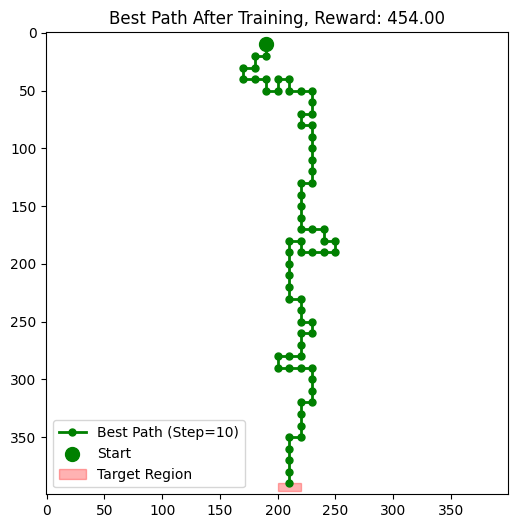

Training Summary:
Starting point: (10, 190)
Target region: ((390, 200), (397, 220))
Number of episodes: 1000
Learning rate (alpha): 0.7
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.3
Exploration rate when target first reached: 0.14871424107031508
Step size per action: 10
Maximum steps per episode: 70
Earliest episode reaching the target: 141
Total times the agent reached the target: 104
Minimum number of steps to reach the target: 54
Best reward achieved: 454.00


In [94]:
maze = np.zeros((400, 400))  # Empty space for initial evaluation. Had been replaced later with the actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (397, 220))  # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.7,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=70  # Shorter max steps
)

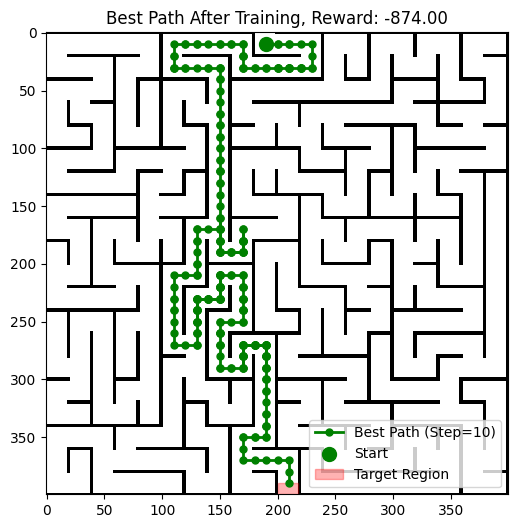

Training Summary:
Starting point: (10, 190)
Target region: ((390, 200), (399, 218))
Number of episodes: 1000
Learning rate (alpha): 0.7
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.7
Exploration rate when target first reached: 0.6930175
Step size per action: 10
Maximum steps per episode: 2000
Earliest episode reaching the target: 3
Total times the agent reached the target: 67
Minimum number of steps to reach the target: 258
Best reward achieved: -874.00


In [95]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (399, 218))  # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.7,
    gamma=0.7,
    epsilon=0.7,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*2  # Shorter max steps
)

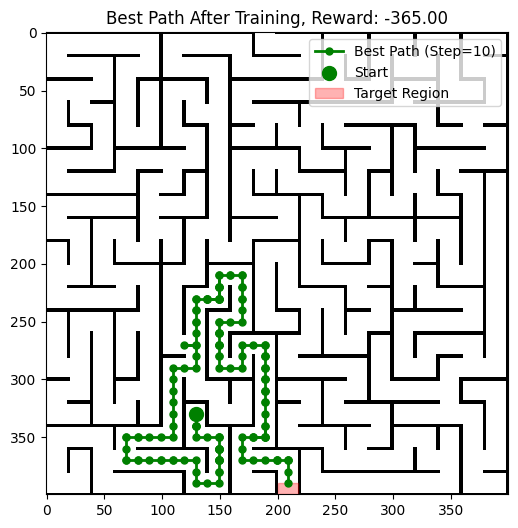

Training Summary:
Starting point: (330, 129)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.8474605262229382
Step size per action: 10
Maximum steps per episode: 1000
Earliest episode reaching the target: 13
Total times the agent reached the target: 47
Minimum number of steps to reach the target: 152
Best reward achieved: -365.00


In [96]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (330, 129)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000  # Shorter max steps
)

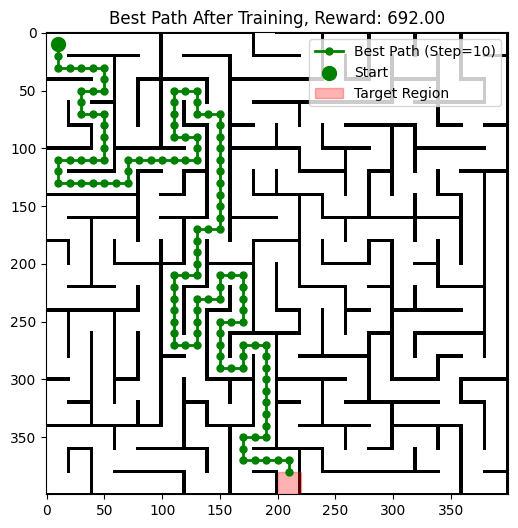

Training Summary:
Starting point: (10, 10)
Target region: ((380, 200), (399, 220))
Number of episodes: 1000
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.3
Exploration rate when target first reached: 0.2970075
Step size per action: 10
Maximum steps per episode: 1000
Earliest episode reaching the target: 3
Total times the agent reached the target: 491
Minimum number of steps to reach the target: 121
Best reward achieved: 692.00


In [97]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 10)  # Start point
end_rect = ((380, 200), (399, 220))  # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

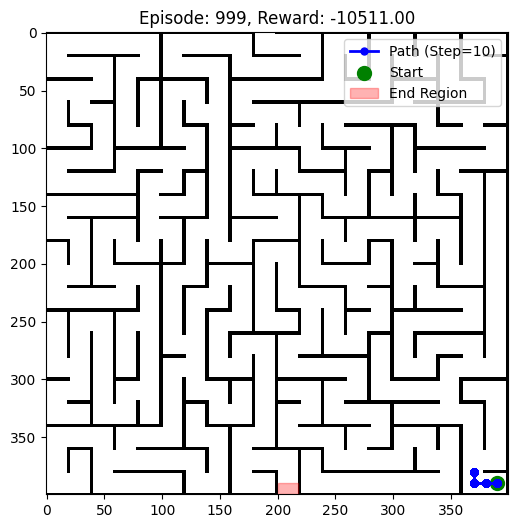

Training Summary:
Starting point: (390, 390)
Target region: ((390, 200), (399, 218))
Number of episodes: 1000
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.3
Exploration rate when target first reached: None
Step size per action: 10
Maximum steps per episode: 1000
Earliest episode reaching the target: None
Total times the agent reached the target: 0
Minimum number of steps to reach the target: inf
Best reward achieved: -inf


In [98]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.3,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

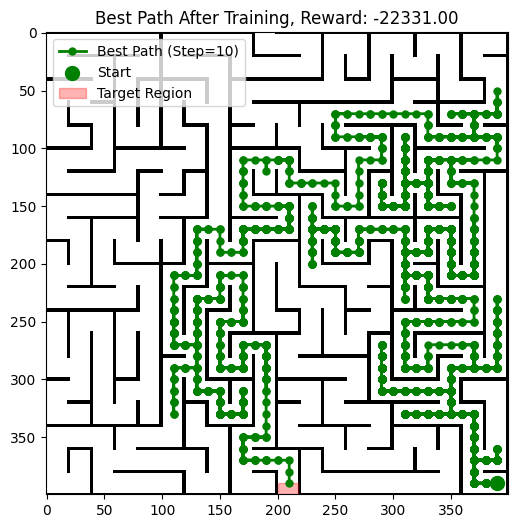

Training Summary:
Starting point: (390, 390)
Target region: ((390, 200), (399, 218))
Number of episodes: 1000
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.8910224999999999
Step size per action: 10
Maximum steps per episode: 30000
Earliest episode reaching the target: 3
Total times the agent reached the target: 3
Minimum number of steps to reach the target: 3186
Best reward achieved: -22331.00


In [100]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=1000,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # High exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*30  # Shorter max steps
)

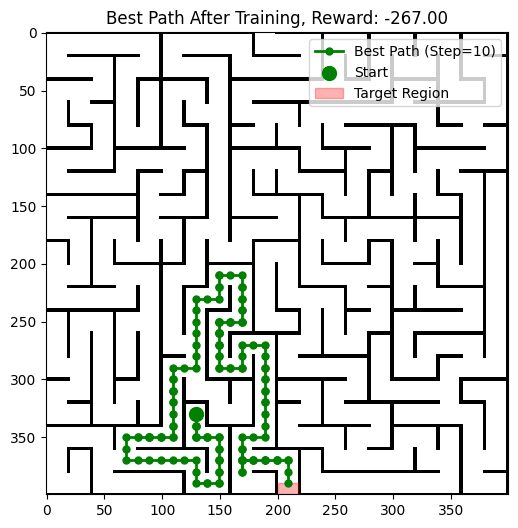

Training Summary:
Starting point: (330, 129)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.9
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 1
Total times the agent reached the target: 172
Minimum number of steps to reach the target: 144
Best reward achieved: -267.00


In [99]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (330, 129)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # High exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

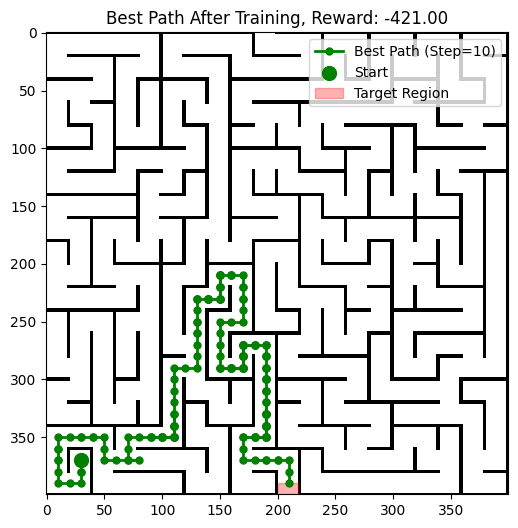

Training Summary:
Starting point: (370, 30)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.9
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 1
Total times the agent reached the target: 180
Minimum number of steps to reach the target: 164
Best reward achieved: -421.00


In [101]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (370, 30)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

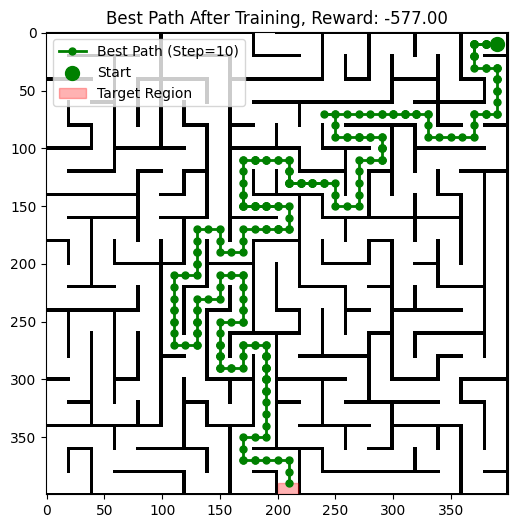

Training Summary:
Starting point: (10, 390)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.8955
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 2
Total times the agent reached the target: 111
Minimum number of steps to reach the target: 268
Best reward achieved: -577.00


In [102]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

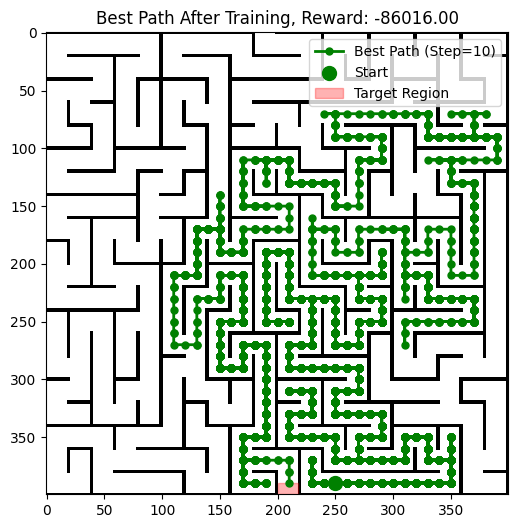

Training Summary:
Starting point: (390, 250)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.8646237392178933
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 9
Total times the agent reached the target: 1
Minimum number of steps to reach the target: 11238
Best reward achieved: -86016.00


In [103]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 250)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*20  # Shorter max steps
)

#New

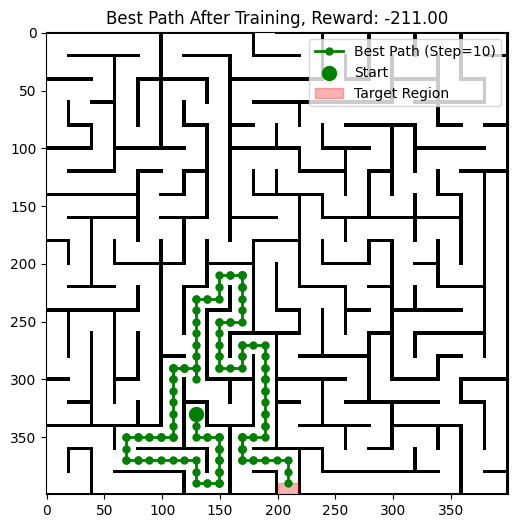

Training Summary:
Starting point: (330, 129)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.9
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 1
Total times the agent reached the target: 179
Minimum number of steps to reach the target: 138
Best reward achieved: -211.00


In [105]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (330, 129)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

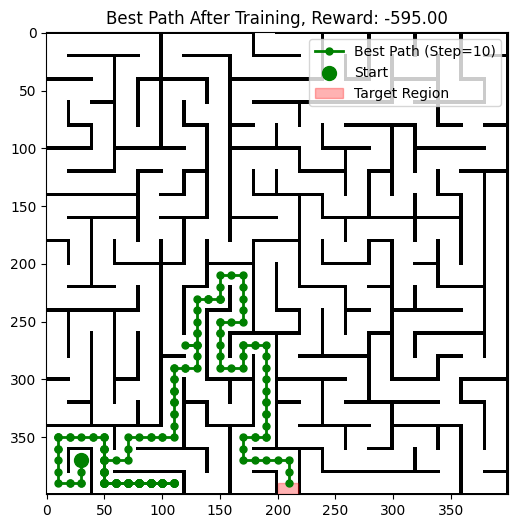

Training Summary:
Starting point: (370, 30)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.9
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 1
Total times the agent reached the target: 181
Minimum number of steps to reach the target: 204
Best reward achieved: -595.00


In [106]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (370, 30)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

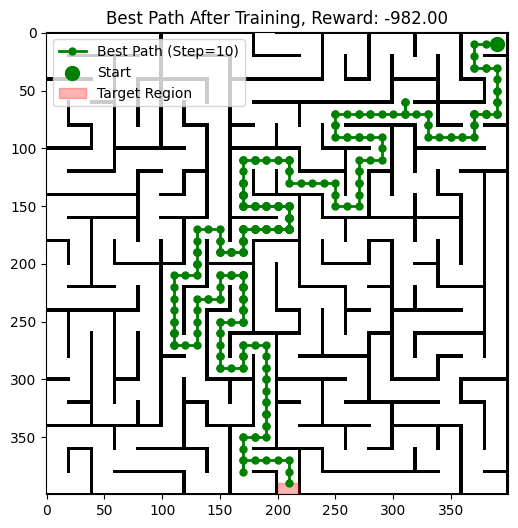

Training Summary:
Starting point: (10, 390)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.8910224999999999
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 3
Total times the agent reached the target: 120
Minimum number of steps to reach the target: 318
Best reward achieved: -982.00


In [107]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

In [ ]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (150, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=200,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 50 episodes
    max_steps=1000*20  # Shorter max steps
)

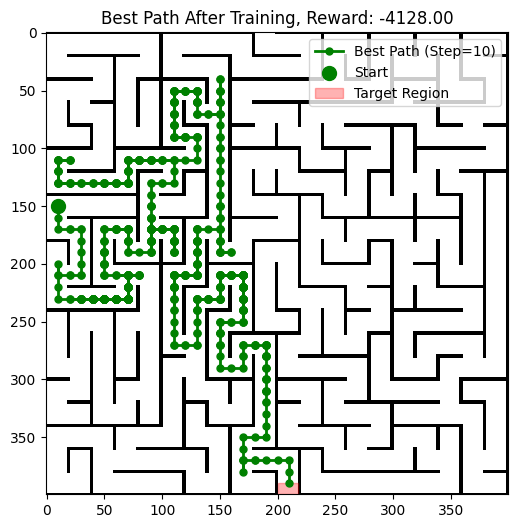

Training Summary:
Starting point: (150, 10)
Target region: ((390, 200), (399, 218))
Number of episodes: 150
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.8
Step size per action: 10
Maximum steps per episode: 5000
Earliest episode reaching the target: 1
Total times the agent reached the target: 8
Minimum number of steps to reach the target: 700
Best reward achieved: -4128.00


In [108]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (150, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=150,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*5  # Shorter max steps
)

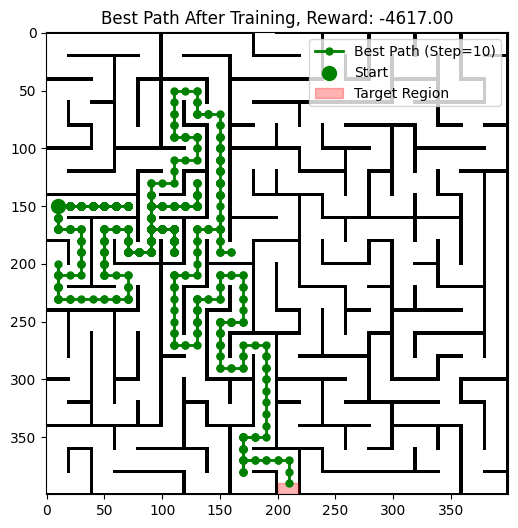

Training Summary:
Starting point: (150, 10)
Target region: ((390, 200), (399, 218))
Number of episodes: 150
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.7762980074850125
Step size per action: 10
Maximum steps per episode: 10000
Earliest episode reaching the target: 7
Total times the agent reached the target: 25
Minimum number of steps to reach the target: 754
Best reward achieved: -4617.00


In [109]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (150, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=150,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

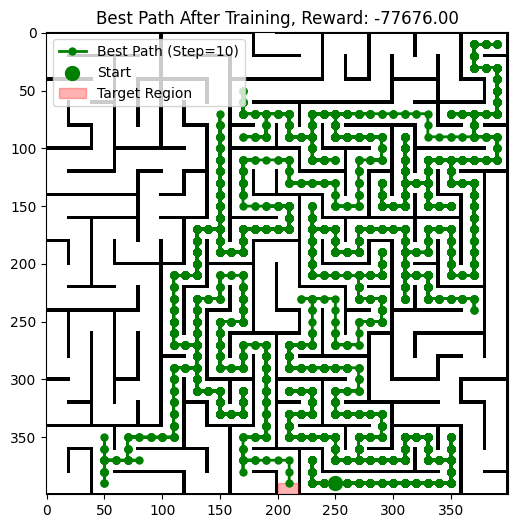

Training Summary:
Starting point: (390, 250)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.8646237392178933
Step size per action: 10
Maximum steps per episode: 20000
Earliest episode reaching the target: 9
Total times the agent reached the target: 2
Minimum number of steps to reach the target: 10128
Best reward achieved: -77676.00


In [110]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 250)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*20  # Shorter max steps
)

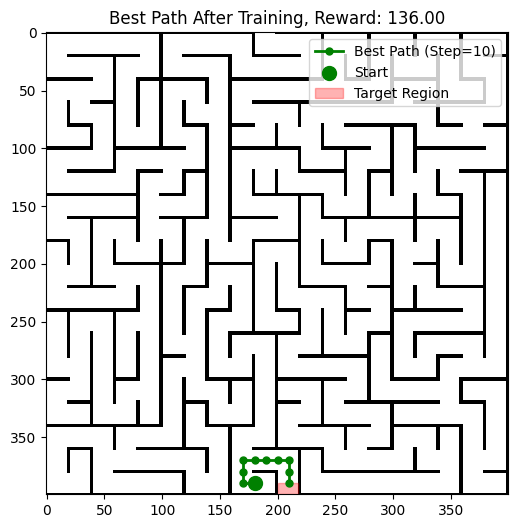

Training Summary:
Starting point: (390, 180)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.8
Step size per action: 10
Maximum steps per episode: 10000
Earliest episode reaching the target: 1
Total times the agent reached the target: 200
Minimum number of steps to reach the target: 9
Best reward achieved: 136.00


In [111]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 180)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

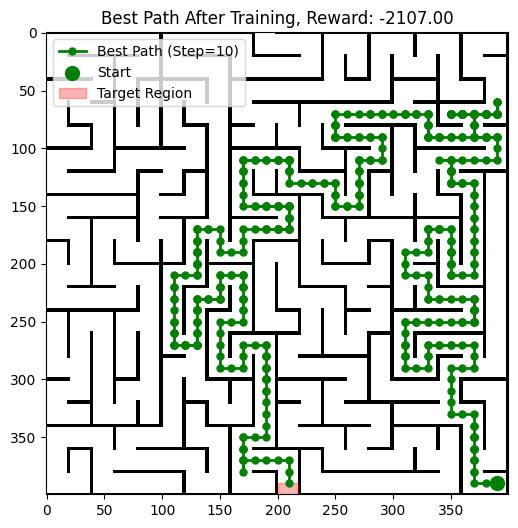

Training Summary:
Starting point: (390, 390)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.6679145338549811
Step size per action: 10
Maximum steps per episode: 10000
Earliest episode reaching the target: 37
Total times the agent reached the target: 7
Minimum number of steps to reach the target: 522
Best reward achieved: -2107.00


In [112]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

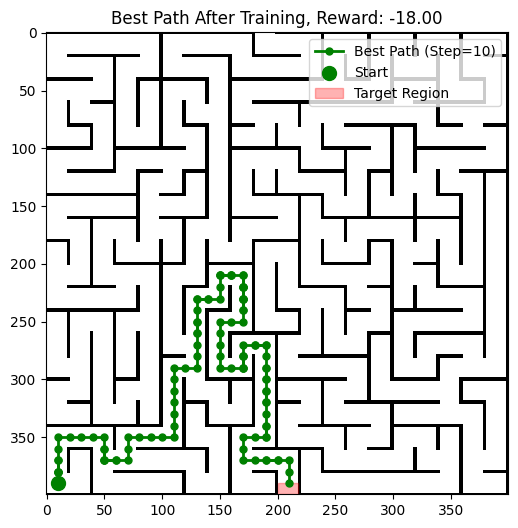

Training Summary:
Starting point: (390, 10)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.8
Step size per action: 10
Maximum steps per episode: 10000
Earliest episode reaching the target: 1
Total times the agent reached the target: 170
Minimum number of steps to reach the target: 112
Best reward achieved: -18.00


In [113]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*10  # Shorter max steps
)

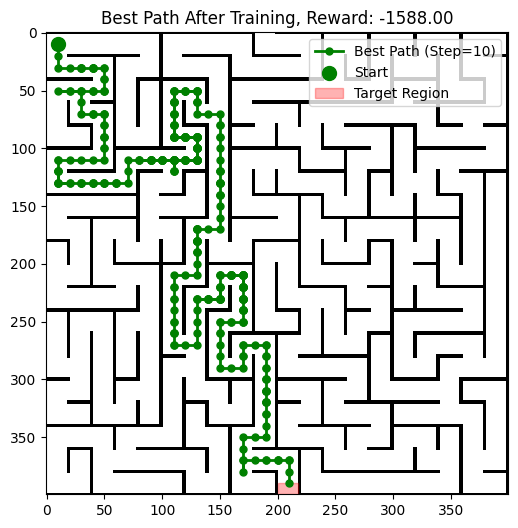

Training Summary:
Starting point: (10, 10)
Target region: ((390, 200), (399, 218))
Number of episodes: 100
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.6987360768203096
Step size per action: 10
Maximum steps per episode: 1000
Earliest episode reaching the target: 28
Total times the agent reached the target: 6
Minimum number of steps to reach the target: 368
Best reward achieved: -1588.00


In [115]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 10)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

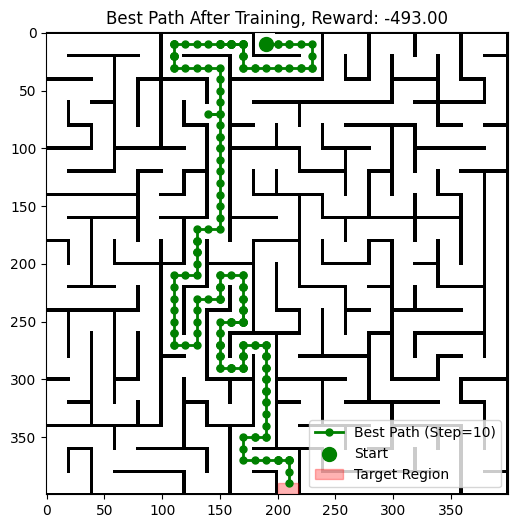

Training Summary:
Starting point: (10, 190)
Target region: ((390, 200), (399, 218))
Number of episodes: 100
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.7647116626860477
Step size per action: 10
Maximum steps per episode: 1000
Earliest episode reaching the target: 10
Total times the agent reached the target: 26
Minimum number of steps to reach the target: 202
Best reward achieved: -493.00


In [116]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 190)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

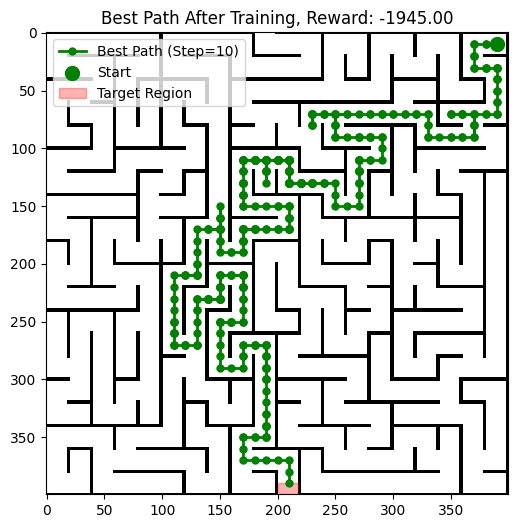

Training Summary:
Starting point: (10, 390)
Target region: ((390, 200), (399, 218))
Number of episodes: 100
Learning rate (alpha): 0.5
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.8
Exploration rate when target first reached: 0.7685544348603495
Step size per action: 10
Maximum steps per episode: 1000
Earliest episode reaching the target: 9
Total times the agent reached the target: 20
Minimum number of steps to reach the target: 426
Best reward achieved: -1945.00


In [117]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (10, 390)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100,
    alpha=0.5,
    gamma=0.7,
    epsilon=0.8,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000  # Shorter max steps
)

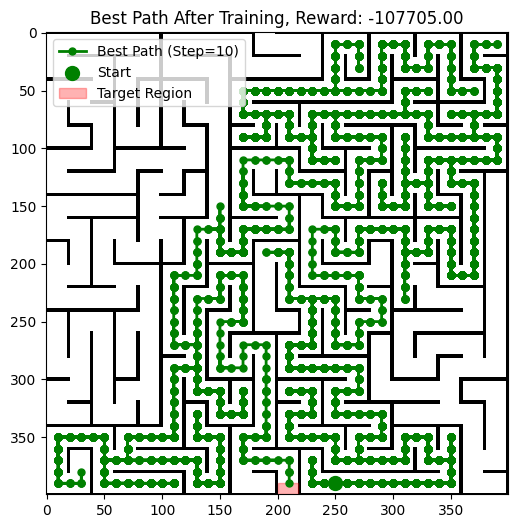

Training Summary:
Starting point: (390, 250)
Target region: ((390, 200), (399, 218))
Number of episodes: 200
Learning rate (alpha): 0.6
Discount factor (gamma): 0.7
Initial exploration rate (epsilon): 0.9
Exploration rate when target first reached: 0.9
Step size per action: 10
Maximum steps per episode: 30000
Earliest episode reaching the target: 1
Total times the agent reached the target: 6
Minimum number of steps to reach the target: 14082
Best reward achieved: -107705.00


In [119]:
maze = preprocess_image(image_path)  # The actual maze environment.

start = (390, 250)  # Start point
end_rect = ((390, 200), (399, 218))   # End rectangular region: top-left to bottom-right

q_values = train_agent(
    maze, start, end_rect,
    episodes=100*2,
    alpha=0.6,
    gamma=0.7,
    epsilon=0.9,  # Moderate exploration rate
    step=10,
    visual_interval=50,  # Visualize every 100 episodes
    max_steps=1000*30  # Shorter max steps
)